# Import libraries

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, interactive
import scipy.spatial.distance as SSD
from skimage.filters import threshold_otsu, threshold_local

# Import data

In [2]:
DATA_DIR = '/home/victor/Mestrado/Disciplinas/Visão Computacional/Projeto Final/bowfire/BowFire'
IMG_DIR = os.path.join(DATA_DIR, 'images')
MASK_DIR = os.path.join(DATA_DIR, 'masks')

In [3]:
list_imgs = [os.path.join(IMG_DIR, x) for x in os.listdir(IMG_DIR)]
list_masks = [os.path.join(MASK_DIR, x) for x in os.listdir(MASK_DIR)]

list_imgs = sorted(list_imgs)
list_masks = sorted(list_masks)

print('Total de imagens', len(list_imgs))
print('Total de máscaras', len(list_masks))

Total de imagens 119
Total de máscaras 119


# Image view

In [9]:
@interact(count = (0, len(list_imgs)-1))
def show_images(count):
    global img
    global dataset_mask
    
    dataset_mask = cv2.imread(list_masks[count])
    img = cv2.imread(list_imgs[count], cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img)

interactive(children=(IntSlider(value=59, description='count', max=118), Output()), _dom_classes=('widget-inte…

# Gaussian Blur

In [10]:
def gaussian_blur(ksize=5, sigmaX=5):
    global blurred
    blurred = cv2.GaussianBlur(img, ksize = (ksize, ksize), sigmaX = sigmaX)
    plt.imshow(blurred);
    
interactive(gaussian_blur, ksize=(0,50,1), sigmaX=(0,5,1))

interactive(children=(IntSlider(value=5, description='ksize', max=50), IntSlider(value=5, description='sigmaX'…

# Simple Threshold

In [6]:
def simple_threshold(img, thresh=5,kernel_opening=5, kernel_closing=5):
    global closing
    global masked_with_morpho
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      
    # opening
    th, dst = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)

    kernel_open = np.array([kernel_opening, kernel_opening])
    opening = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel_open)

    # closing
    kernel_close = np.array([kernel_closing, kernel_closing])
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_close)
    
    mask_with_morpho = cv2.multiply(gray, (closing//255))

    fig, ax = plt.subplots(1,3, figsize = (15,5))
    ax[0].imshow(dst,'gray')
    ax[0].set_title('threshold img')
    
    ax[1].imshow(opening, 'gray')
    ax[1].set_title('opening')

    ax[2].imshow(closing, 'gray')
    ax[2].set_title('closing')
    
    for axs in ax:
        axs.axis('Off')

In [7]:
interactive(simple_threshold(blurred, (0,100,1)))

TypeError: Argument 'thresh' can not be treated as a double

## Show image

interactive(children=(IntSlider(value=59, description='count', max=119), FloatSlider(value=0.0, description='t…

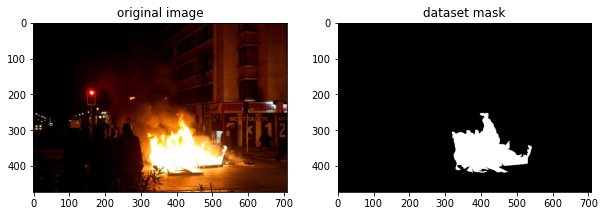

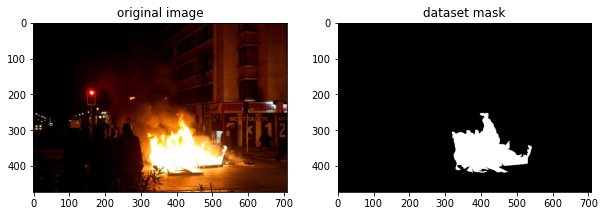

In [44]:
def math_morpho(count,thresh, kernel_opening, kernel_closing):
    global original_img
    global mask
    
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    original_img = plt.imread(list_imgs[count])
    mask = plt.imread(list_masks[count])
    
    axs[0].imshow(original_img)
    axs[0].set_title('original image')
    axs[1].imshow(mask)
    axs[1].set_title('dataset mask')
    
    simple_thresh(original_img,thresh, kernel_opening, kernel_closing)
    
interactive(math_morpho,
            count = (0, len(list_imgs)),
            thresh=(0,1, 1/10),
            kernel_opening = (1,20,1),
            kernel_closing = (1,20,1))

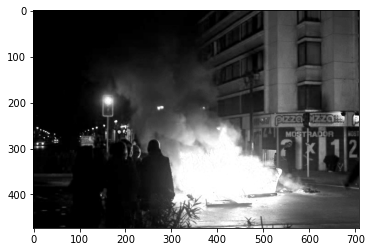

In [116]:
multiplied_img = original_img[:,:,0] * closing
plt.imshow(multiplied_img,'gray');

# Adaptative Threshold

In [28]:
@interact(count = (0, len(list_imgs)), block_size = (0,50,1), offset = (0,50,1))
def _(count, block_size, offset):
    global img
    global std_img
    global mask
    global binary_global
    
    
    mask =cv2.imread(list_masks[count])
    
    img =cv2.imread(list_imgs[count], cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = img / 255.0
    
    std_img =  (img - np.mean(img)) / np.std(img)
    
    gray = cv2.imread(list_imgs[count], cv2.IMREAD_GRAYSCALE)
    #gray = gray / 255.0
    
    global_thresh = threshold_otsu(gray)
    binary_global = gray > global_thresh

    block_size = 35
    adaptive_thresh = threshold_local(gray, block_size, offset=offset)
    binary_adaptive = gray > adaptive_thresh

    
    fig, ax = plt.subplots(2,2, figsize=(10,5))
    ax[0,0].imshow(np.squeeze(img))
    ax[0,0].set_title('original')
    ax[0,0].axis('Off')
    
    ax[0,1].imshow(mask)
    ax[0,1].set_title('mask')
    ax[0,1].axis('Off')
    
    ax[1,0].imshow(binary_global, 'gray')
    ax[1,0].set_title('global_thresh')
    ax[1,0].axis('Off')
    
    ax[1,1].imshow(binary_adaptive,'gray')
    ax[1,1].set_title('adaptive_thresh')
    ax[1,1].axis('Off')

interactive(children=(IntSlider(value=59, description='count', max=119), IntSlider(value=25, description='bloc…

In [29]:
binary_global.shape

(473, 709)

In [37]:
plt.imshow(img[:,:,2] @ binary_global);

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 473 is different from 709)

In [10]:
multiply_img = img[:,:,0] * binary_global
plt.imshow(a,'gray');

NameError: name 'a' is not defined

# Color Threshold

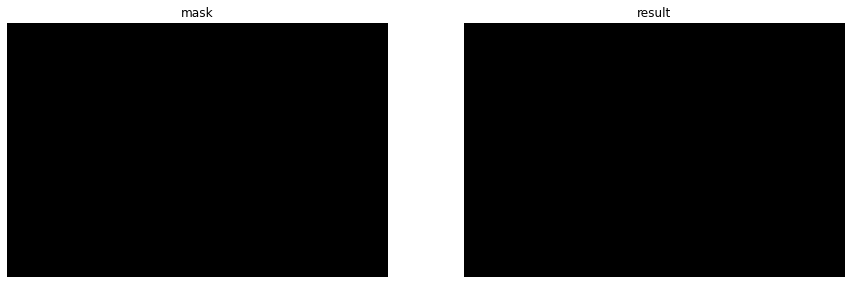

In [8]:
def color_threshold(img):

    global mask
    global result
    
    # creates a copy to modify the features
    result = img.copy()
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = hsv/255
    
    # fire bounds
    lower_red = np.array([0, 0, 100])
    upper_red = np.array([100, 100, 100])
    mask =  cv2.inRange(hsv, lower_red, upper_red)
    
    #lower_yellow = np.array([20, 93, 0])
    #upper_yellow = np.array([45, 255, 255])
    #mask1 =  cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    # mask
    #mask = mask0 + mask1
    
    #fire = np.zeros_like(img, np.uint8)
    #green[mask>0] = img[exhaust_color]
    
    # mask with and operation
    result = cv2.bitwise_and(result, result, mask=mask)
    
    
    fig,axs = plt.subplots(1,2, figsize=(15,5))
    axs[0].imshow(mask,'gray')
    axs[0].set_title('mask')
    axs[1].imshow(result)
    axs[1].set_title('result')
    
    for ax in axs:
        ax.axis('Off')

    
color_threshold(blurred)

In [95]:
#ray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
def th_one_img(img, kernel_opening, kernel_closing):
    # opening
    kernel_open = np.array([2, 2])
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_opening)

    # closing
    kernel_close = np.array([2, 2])
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_closing)
    plt.imshow(closing);
    
    ax[0].imshow(img)
    ax[0].set_title('original image')
    ax[1].imshow(closing)
    ax[1].set_title('dataset mask')

    for axs in ax:
        axs.axis('Off')

interactive(th_one_img,
            result,
            kernel_opening = (1,5,1),
            kernel_closing = (1,5,1))


AttributeError: 'numpy.ndarray' object has no attribute 'get'

In [ ]:
@interact(kernel_opening=(0,10,1), kernel_closing=(0,10,1))
def _(img, kernel_opening, kernel_closing):
    color_threshold(img)

# Mahalanobis Distance

The formula to compute Mahalanobis distance is as follows:

$D^2 = (x-m)^{T} \cdot C^{-1} \cdot (x-m)$

**Where,**



$D^2$ is the square of the Mahalanobis distance. 

$x$          is the vector of the observation (row in a dataset), 

$m$          is the vector of mean values of independent variables (mean of each column), 

$C^{-1}$     is the inverse covariance matrix of independent variables. 

---

$(x – m)$ is essentially the distance of the vector from the mean. We then divide this by the covariance matrix (or multiply by the inverse of the covariance matrix).

If you think about it, this is essentially a multivariate equivalent of the regular standardization (z = (x – mu)/sigma). That is, z = (x vector) – (mean vector) / (covariance matrix).

In [97]:
# Equação: (u-mi)^T @ A^{-1} @ (u-mi)
# Passos para cálculo da matriz de covariância = A
''' 
Passo 01: média da variável.

    ||u - mi ||, dado que:
        * u = pixel da imagem
        * mi = média de cada uma das componentes - R,G,B. É um vetor
        
Passo 02: cálculo da variância de cada uma das componentes em relação a componente média.

    sigma_r, sigma_g, sigma_b
    Pega cada uma das componentes de entrada, menos mi em termos quadráticos
    
Passo 03: matriz de covariância o quanto componente varia ou individualmente ou conjuntamente

A = sigma_red_red    sigma_red_green    sigma_red_blue
    sigma_green_red  sigma_green_green  sigma_green_blue
    sigma_blue_red   sigma_blue_green   sigma_blue_blue

Passo 04: Cálculo da inversa da matriz de covariância, A^{-1}

'''
def mahalanobis(img):
    # passo 01
    img_red   = img[:,:,0]
    img_green = img[:,:,1]
    img_blue  = img[:,:,2]

    mean_red   = np.mean(img[:,:,0])
    mean_green = np.mean(img[:,:,1])
    mean_blue  = np.mean(img[:,:,2])

    mi = np.array([mean_red, mean_green, mean_blue])
    #mi = np.array([184,134,11])
    
    # (u-mi)^T @ A^{-1} @ (u-mi)
    # passo 02
    # N = pontos de entrada
    #sigma_red = (1 / N-1) * np.sum((u - mean_red)**2)
    #sigma_green = (1 / N-1) * np.sum((u - mean_green)**2)
    #sigma_blue = (1 / N-1) * np.sum((u - mean_blue)**2)
    
    # matriz de covariância
    covariance = np.cov([img_red.ravel(), img_green.ravel(), img_blue.ravel()])
    inv_cov = np.linalg.inv(covariance) # inv. covariance matrix
    
    height = img.shape[0]
    weigth = img.shape[1]
    
    result = np.zeros_like(img, dtype='float64')
    
    for h in range(height):
        for w in range(weigth):
            # array with particular pixels from each image
            u = np.array([img_red[h, w], img_green[h, w],img_blue[h, w]])
            
            # calculate mahalanobis distance and insert value as a pixel
            # scipy.spatial.distance.mahalanobis(u, mi, A^{-1})
            # sqrt(u-mi)A^{-1} * (u-mi).T
            result[h, w] = SSD.mahalanobis(u, mi, inv_cov)
    return result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


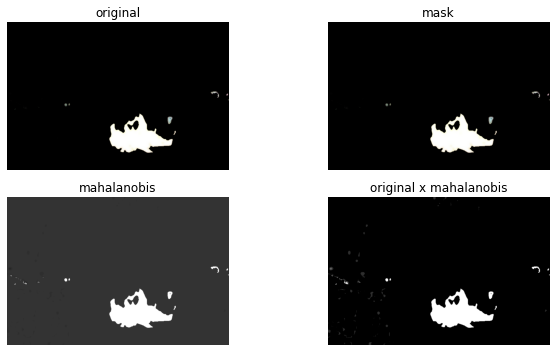

In [150]:
# recebe a img e a mask da função da célula acima

#@interact(count = (0, len(list_imgs)))
def show_mahalanobis(original_img, img):
    global gray
    global mahalanobis_img
    global multiplied_img
    

    
    mahalanobis_img = mahalanobis(img)
    multiplied_img = img * mahalanobis_img

    
    fig, ax = plt.subplots(2,2, figsize=(10,5))
    ax[0,0].imshow(original_img, 'gray')
    ax[0,0].set_title('original')
    ax[0,0].axis('Off')
    
    ax[0,1].imshow(original_img)
    ax[0,1].set_title('mask')
    ax[0,1].axis('Off')
    
    ax[1,0].imshow(mahalanobis_img, 'gray')
    ax[1,0].set_title('mahalanobis')
    ax[1,0].axis('Off')
    
    ax[1,1].imshow(multiplied_img, 'gray')
    ax[1,1].set_title('original x mahalanobis')
    ax[1,1].axis('Off')
    
    plt.tight_layout()

#view_images(std_img)
show_mahalanobis(result, result)

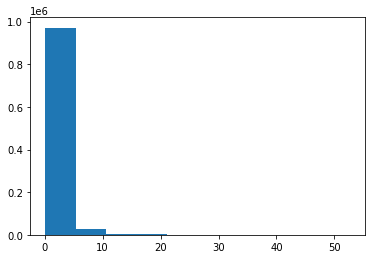

In [151]:
plt.hist(mahalanobis_img.ravel());

In [200]:
maha = mahalanobis_img.copy()

In [201]:
maha.min()

0.10750405826407199

In [202]:
maha[maha<5] = 0
#maha[maha>=0.05] = 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


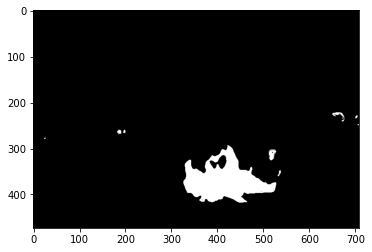

In [203]:
plt.imshow(maha,'gray');

In [22]:
#ray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
def th_one_img(img, thresh, kernel_opening, kernel_closing):
    # opening
    th, dst = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)

    kernel_open = np.array([2, 2])
    opening = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel_opening)

    # closing
    kernel_close = np.array([2, 2])
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_closing)
    plt.imshow(closing);
    
    ax[0].imshow(original_img)
    ax[0].set_title('original image')
    ax[1].imshow(dst)
    ax[1].set_title('dataset mask')

    for axs in ax:
        axs.axis('Off')

interactive(th_one_img,
            mahalanobis_img,
            thresh=(0,1, 1/10),
            kernel_opening = (1,5,1),
            kernel_closing = (1,5,1))


AttributeError: 'numpy.ndarray' object has no attribute 'get'

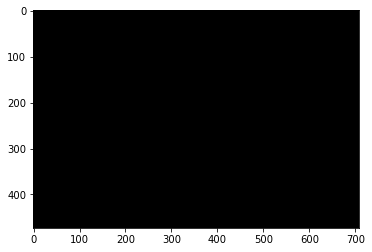

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


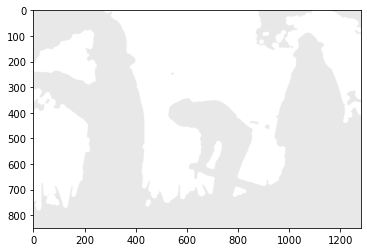

In [83]:
plt.imshow(mahalanobis_img);

In [94]:
@interact(ksize = (1, 51, 2), sigmaX = (0.1, 10.0, 0.1))
def gaussian_blur(ksize, sigmaX):
    global blurred
    blurred = cv2.GaussianBlur(multiply_img, ksize = (ksize, ksize), sigmaX = sigmaX)
    plt.imshow(multiply_img, 'gray')

interactive(children=(IntSlider(value=25, description='ksize', max=51, min=1, step=2), FloatSlider(value=5.0, …

In [95]:
def fire_bounds(img, kernel='normal',kernel_opening=5, kernel_closing=5):
    global opening
    global closing
    
    # opening
    if kernel == 'normal':
        kernel_open = np.array([kernel_opening, kernel_opening])
        opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_open)

        # closing
        kernel_close = np.array([kernel_closing, kernel_closing])
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_close)
        masked_with_morpho = cv2.multiply(img, (closing//255))

        fig, ax = plt.subplots(1,3, figsize = (15,5))
        ax[0].imshow(np.squeeze(img),'gray')
        ax[0].set_title('original img')
        ax[1].imshow(np.squeeze(opening), 'gray')
        ax[1].set_title('opening')
        ax[2].imshow(np.squeeze(closing), 'gray')
        ax[2].set_title('closing')

    else:
        kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_opening, kernel_opening))
        opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_open)

        # closing
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_closing, kernel_closing))
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_close)
        masked_with_morpho = cv2.multiply(img, (closing//255))
        
        fig, ax = plt.subplots(1,3, figsize = (15,5))
        ax[0].imshow(np.squeeze(img),'gray')
        ax[0].set_title('original img')
        ax[1].imshow(np.squeeze(opening), 'gray')
        ax[1].set_title('opening')
        ax[2].imshow(np.squeeze(closing), 'gray')
        ax[2].set_title('closing')

        for axs in ax:
            axs.axis('Off')

In [97]:
@interact(count = (0, len(list_imgs)), 
          kernel = ['normal','ellipse'],
          kernel_opening = (1,20,1), kernel_closing = (1,30,1))

def config_bounds(count, kernel, kernel_opening, kernel_closing):
    #global img
    #global mask    
    fire_bounds(multiply_img, kernel_opening, kernel_closing)
        
# open = 3
# close = 20

interactive(children=(IntSlider(value=59, description='count', max=119), Dropdown(description='kernel', option…

In [98]:
@interact(thresh = (0.0, 5.0))
def view_th(thresh):
    global threshed_img
    #new_img = cv2.multiply(multiply_img, (closing))

    th, threshed_img = cv2.threshold(closing, thresh, 255, cv2.THRESH_BINARY)
    
    plt.imshow(threshed_img, 'gray');

interactive(children=(FloatSlider(value=2.5, description='thresh', max=5.0), Output()), _dom_classes=('widget-…

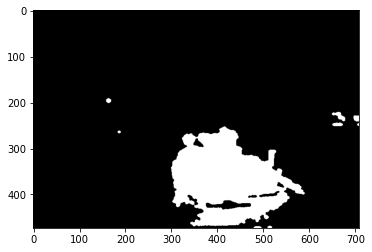

In [99]:
final_img = cv2.multiply(closing, (threshed_img))
plt.imshow(final_img,'gray')

# Mahalanobis Distance


        Mahalonobis distance is the distance between a point and a distribution. 
        And not between two distinct points. 
        It is effectively a multivariate equivalent of the Euclidean distance.

https://www.machinelearningplus.com/statistics/mahalanobis-distance/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


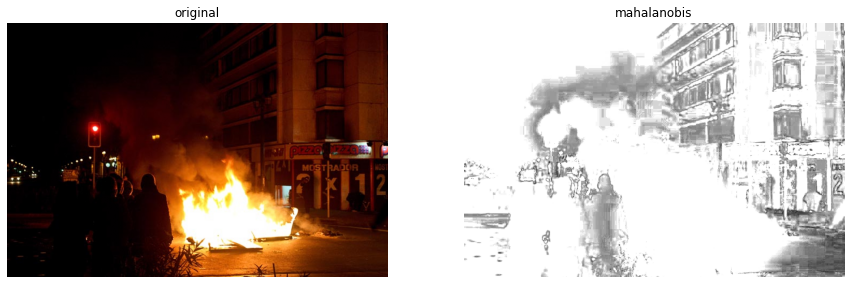

In [134]:
# Equação: (u-mi)^T @ A^{-1} @ (u-mi)
# Passos para cálculo da matriz de covariância = A
''' 
Passo 01: média da variável.

    ||u - mi ||, dado que:
        * u = pixel da imagem
        * mi = média de cada uma das componentes - R,G,B. É um vetor
        
Passo 02: cálculo da variância de cada uma das componentes em relação a componente média.

    sigma_r, sigma_g, sigma_b
    Pega cada uma das componentes de entrada, menos mi em termos quadráticos
    
Passo 03: matriz de covariância o quanto componente varia ou individualmente ou conjuntamente

A = sigma_red_red    sigma_red_green    sigma_red_blue
    sigma_green_red  sigma_green_green  sigma_green_blue
    sigma_blue_red   sigma_blue_green   sigma_blue_blue

Passo 04: Cálculo da inversa da matriz de covariância, A^{-1}

'''
def mahalanobis(img):
    # passo 01
    img_red   = img[:,:,0]
    img_green = img[:,:,1]
    img_blue  = img[:,:,2]

    mean_red   = np.mean(img[:,:,0])
    mean_green = np.mean(img[:,:,1])
    mean_blue  = np.mean(img[:,:,2])

    mi = np.array([mean_red, mean_green, mean_blue])

    # (u-mi)^T @ A^{-1} @ (u-mi)
    # passo 02
    # N = pontos de entrada
    #sigma_red = (1 / N-1) * np.sum((u - mean_red)**2)
    #sigma_green = (1 / N-1) * np.sum((u - mean_green)**2)
    #sigma_blue = (1 / N-1) * np.sum((u - mean_blue)**2)
    
    # matriz de covariância
    covariance = np.cov([img_red.ravel(), img_green.ravel(), img_blue.ravel()])
    inv_cov = np.linalg.inv(covariance) # inv. covariance matrix
    
    height = img.shape[0]
    weigth = img.shape[1]
    
    result = np.zeros_like(img, dtype='float64')
    
    for h in range(height):
        for w in range(weigth):
            # array with particular pixels from each image
            v = np.array([img_red[h, w], img_green[h, w],img_blue[h, w]])
            # calculate mahalanobis distance and insert value as a pixel
            result[h, w] = SSD.mahalanobis(v, mi, inv_cov)
    return result

new_img = mahalanobis(img)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(img)
ax[0].set_title('original')
ax[1].imshow(new_img)
ax[1].set_title('mahalanobis')


for axs in ax:
    axs.axis('Off')